# Prévision de risque de retards pour les avions

**Réalisé par Mohamed Ali Tlich, Ahmed Chaabouni et Ismail Dinar**

# Objectif

**Le but de ce projet est de construire un modèle de prédiction des retards (de 15 minutes ou plus) de vol exploitant les données de performances de vol à l'heure et d'utiliser le modèle pour obtenir des informations sur les retards de vol passés. **

# Les librairies utilisées

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer ,StandardScaler , LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes
import operator
import random
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# Ensemble de données utilisées

**Dans ce projet nous allons utiliser un ensemble de données que nous avons trouver dans le site du département américain des Transports (DoT) et qui comporte des données sur les vols intérieurs sans escale de l'année 2018. Ces données sont enregistrées dans les fichiers "On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_*.csv". **


# Chargement des données

In [2]:
data = pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_1.csv')
for i in range(2,13):
    data = data.append(pd.read_csv('On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_'+str(i)+'.csv'))

C:\Users\sm41l\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (48,69,76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\sm41l\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (48,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\sm41l\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (48,76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(7213446, 110)

**L'ensemble de données intial contient 7213446 lignes et 110 attributs.**

# Nettoyage des données

➠ Nous allons supprimer les colonnes contenant plus de 2/3 des entrées manquantes.

In [4]:
for column in data.columns:
    if data[column].isnull().sum() > len(data)*(2/3):
        data.drop(column, axis = 1, inplace=True)

➠ La nouvelle taille de l'ensemble de données est:

In [5]:
data.shape

(7213446, 56)

➠ On remarque bien que les colonnes contenant beaucoup de valeurs manquantes ont été éliminées.

En deuxième lieu nous allons supprimer les colonnes qui ne fournissent pas d'informations utiles pour cette analyse (les colonnes qui ont la meme valeur. Par exemple la colonne "Year" est toujours égale à 2018)

In [6]:
for column in data.columns:
    if data[column].nunique() == 1:
        data.drop(column, axis = 1, inplace = True)

➠ Nous avons obtenu un ensemble de données de taille:

In [7]:
data.shape

(7213446, 54)

# Analyse des données

Cette phase nous permet d'identifier les features qui semblent prometteuses dans l'analyse pour prédire les retards d'arrivée des vols. Notre variable cible est ArrDel15 - Indicateur de retard d'arrivée, 15 minutes ou plus (1 = retard, 0 = pas de retard)

0.0    5723696
1.0    1352710
Name: ArrDel15, dtype: int64
ratio :  0.18752618374075303


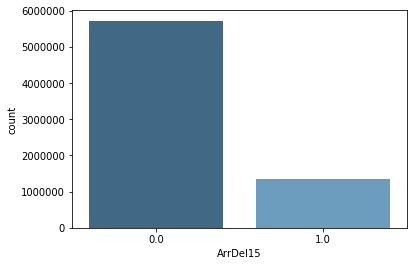

In [8]:
arr_del_15_class_distribution = data['ArrDel15'].value_counts()
print(arr_del_15_class_distribution)
print('ratio : ', arr_del_15_class_distribution.min()/len(data))
sns.countplot(x='ArrDel15',data=data, palette="Blues_d")

D'après le graphe ci-dessus, on remarque que l'ensemble de données est très fortement asymétrique, les retards d'arrivée positifs ne constituant que 18% des échantillons. Donc si nous n'équilibrons pas la distribution des classes, on risque que le classifieur apprenne une classe mieux que l'autre (le classificateur qui prédit qu'il n'y a pas de retard à l'arrivée a une précision de 82%.).

** ➠ Equilibrage des classes **

1.0    1352710
0.0    1352710
Name: ArrDel15, dtype: int64


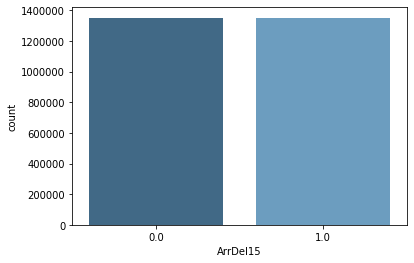

In [9]:
arr_del_15_zero = data[data['ArrDel15']==0].tail(arr_del_15_class_distribution.min())
arr_del_15_one = data[data['ArrDel15']==1]
data = arr_del_15_zero.append(arr_del_15_one)
arr_del_15_class_distribution = data['ArrDel15'].value_counts()
print(arr_del_15_class_distribution)
sns.countplot(x='ArrDel15',data=data, palette="Blues_d")
data = data.reset_index(drop=True)

➠ La nouvelle taille de l'ensemble de données est:

In [10]:
data.shape

(2705420, 54)

Maintenant, on passe à une analyse des différents attributs (features) et leur pertinence dans la déduction des retards de vols.

La fonction suivante permet de visualiser la variation du nombre des vols qui arrivent en retard par rapport à différents attributs.

In [11]:
def bar_plot(feature,title):
    plt.figure(figsize=(12, 5))
    order = np.unique(list(data[feature]))
    ax = sns.barplot(x=feature,y ='ArrDel15', data=data, color = "red" , order = order , estimator = np.sum)
    plt.xticks(rotation=90)
    plt.title(title)

**Date des vols**

Nous allons commencer par l'affichage de la variation de nombre total de vols en retard en fonction de la date du vol.

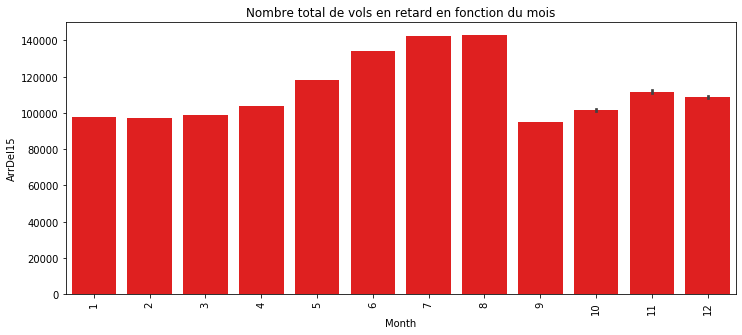

In [12]:
bar_plot('Month', 'Nombre total de vols en retard en fonction du mois')

On affiche le nombre des vols qui arrivent en retard par rapport au jour de la semaine

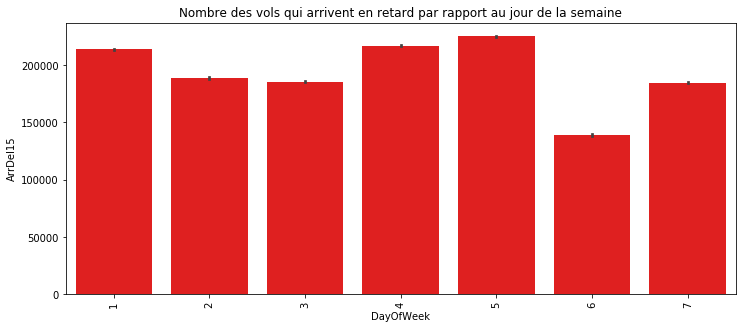

In [13]:
bar_plot('DayOfWeek','Nombre des vols qui arrivent en retard par rapport au jour de la semaine')

➠ Il n'existe pas un "pattern" apparent dans ces valeurs, mais on remarque une augmentation de nombre des retards entre mercredi et jeudi.

Pour une meilleure visualisation, nous allons diviser la semaine en deux : weekends et non weekends.

In [14]:
def split_week(cols):
    if cols in [1,7]:
        return "Weekend"

    else:
        return "Weekdays"
data['Week']  = data['DayOfWeek'].apply(split_week)
data.drop("DayOfWeek", axis = 1, inplace = True)

Text(0, 0.5, 'Probabilité de retard')

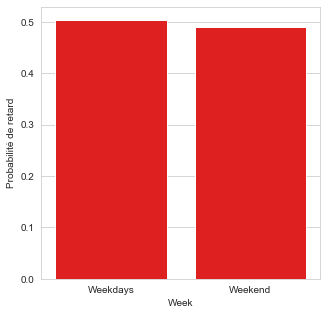

In [15]:
week_grouped1 = data.groupby('Week')["ArrDel15"].sum()
week_grouped2 = data.groupby('Week')["ArrDel15"].count()
week_grouped = pd.concat([week_grouped1, week_grouped2],axis=1, keys=["sum", "count"])
week_grouped["Probability of Arrival Delay15"] = week_grouped["sum"]/week_grouped["count"]
plt.figure(figsize=(5, 5))
sns.set_style('whitegrid')
sns.barplot(x=week_grouped.index, y ='Probability of Arrival Delay15', data=week_grouped, color ='red')
plt.ylabel("Probabilité de retard")

➠ Le nombre moyen de retards est moindre en weekend par rapport aux autres jours.

On affiche le nombre des vols qui arrivent en retard par rapport au jour du mois

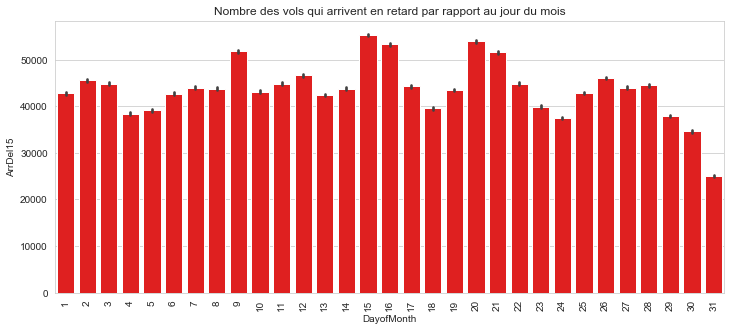

In [16]:
bar_plot('DayofMonth','Nombre des vols qui arrivent en retard par rapport au jour du mois')

Pour une meilleure visualisation, nous allons diviser le mois en 5 : semaine1, semaine2, semaine3, semaine4 et semaine5.

In [17]:
def split_month(cols):
    if cols in [1,2,3,4,5,6,7]:
        return "weekI"

    elif cols in [8,9,10,11,12,13,14]:
        return "weekII"

    elif cols in [15,16,17,18,19,20,21]:
        return "weekIII"

    elif cols in [22,23,24,25,26,27,28]:
        return "weekIV"

    else:
        return "weekV"
    
data['Month'] = data["DayofMonth"].apply(split_month)
data.drop("DayofMonth", axis = 1, inplace = True)

Text(0, 0.5, 'Nombre moyen de retards')

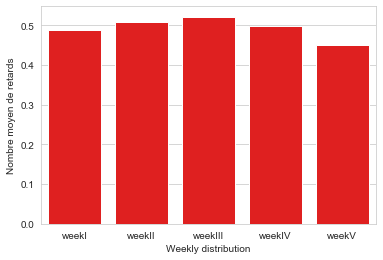

In [18]:
Month_grouped1 = data.groupby('Month')["ArrDel15"].sum()
Month_grouped2 = data.groupby('Month')["ArrDel15"].count()
Month_grouped = pd.concat([Month_grouped1, Month_grouped2],axis=1, keys=["sum", "count"])
Month_grouped["Average number of delays"] = Month_grouped["sum"]/Month_grouped["count"]
sns.barplot(x=Month_grouped.index, y ='Average number of delays', data=Month_grouped, color ='red')
plt.xlabel("Weekly distribution")
plt.ylabel("Nombre moyen de retards")

➠ On remarque que nombre moyen de retards atteint un maximum au mi-mois. La dernière semaine étant la semaine avec le nombre moyen de retards minimal.

On affiche le nombre des vols qui arrivent en retard par rapport à l'heure d'arrivée

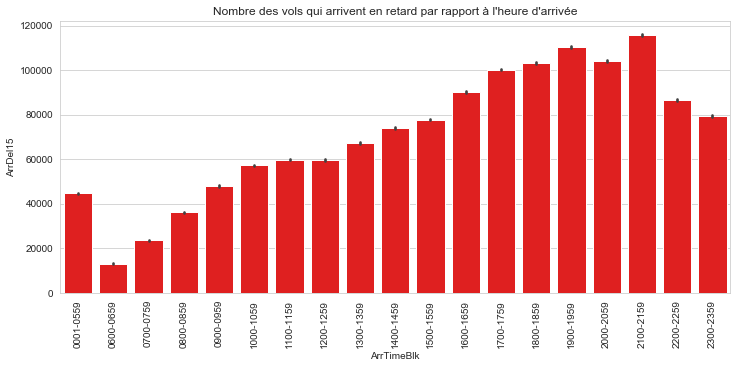

In [19]:
bar_plot('ArrTimeBlk','Nombre des vols qui arrivent en retard par rapport à l\'heure d\'arrivée')

On affiche le nombre des vols qui arrivent en retard par rapport à l'heure de départ

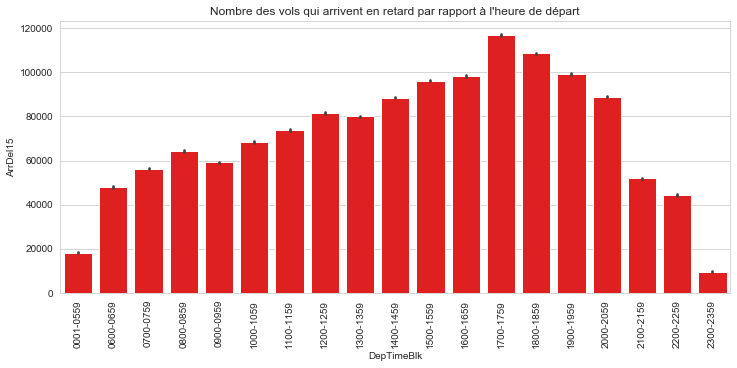

In [20]:
bar_plot('DepTimeBlk','Nombre des vols qui arrivent en retard par rapport à l\'heure de départ')

Pour une meilleure visualisation, nous allons diviser le jour en 3: l'après midi, le soir et le matin.

In [21]:
def split_day(cols):
    if cols >= 600 and cols < 1200:
        return "Morning"
    elif cols >= 1200 and cols < 1600:
        return "Afternoon"
    else:
        return "Evening"

data['Arrival_Time'] = data["CRSArrTime"].apply(split_day)
data.drop("CRSArrTime", axis = 1, inplace = True)

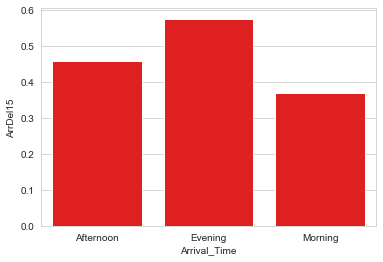

In [22]:
arrtime_grouped = data.groupby('Arrival_Time').mean()
sns.barplot(x=arrtime_grouped.index, y ="ArrDel15", data=arrtime_grouped, color ='red')

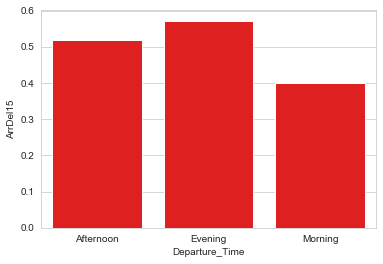

In [23]:
data['Departure_Time'] = data["CRSDepTime"].apply(split_day)
data.drop("CRSDepTime", axis = 1, inplace = True)
deptime_grouped = data.groupby('Departure_Time').mean()
sns.barplot(x=deptime_grouped.index, y ="ArrDel15", data=deptime_grouped, color ='red')

Les retards de départ et d'arrivée semblent importants en soirée

**Compagnies aériennes**

Nous allons afficher la variation de nombre total de vols en retard en fonction de la compagnie aérienne.

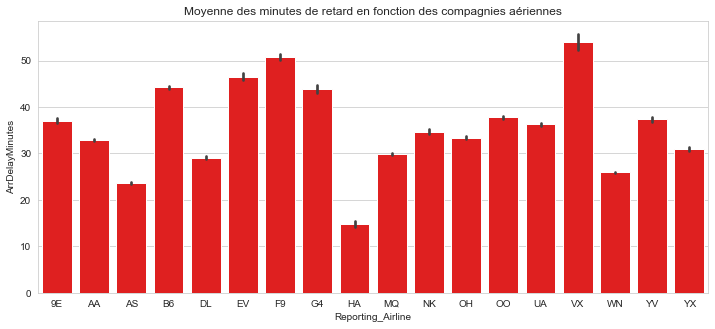

In [24]:
plt.figure(figsize=(12, 5))
carrier_order = np.unique(list(data['Reporting_Airline']))
sns.barplot(x='Reporting_Airline',y ='ArrDelayMinutes', data=data, color = "red" , order = carrier_order)
fig = plt.title("Moyenne des minutes de retard en fonction des compagnies aériennes")

On affiche la probabilité d'avoir un retard d'arrivée en fonction des compagnies aériennes

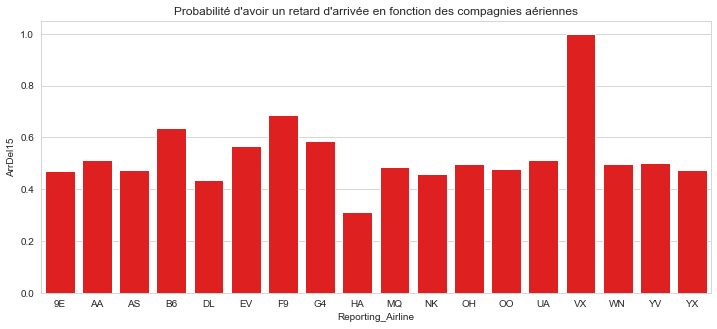

In [25]:
plt.figure(figsize=(12, 5))
airline_grouped = data.groupby('Reporting_Airline').mean()
sns.barplot(x=airline_grouped.index, y ="ArrDel15", data=airline_grouped, color ='red')
fig = plt.title("Probabilité d'avoir un retard d'arrivée en fonction des compagnies aériennes")

➠ On remarque que la compagnie aérienne "VX" (Virgin America) semble avoir une probabilté de retards d'arrivée de vol très importantes.

On affiche la probabilité d'avoir un retard de départ en fonction des compagnies aériennes.

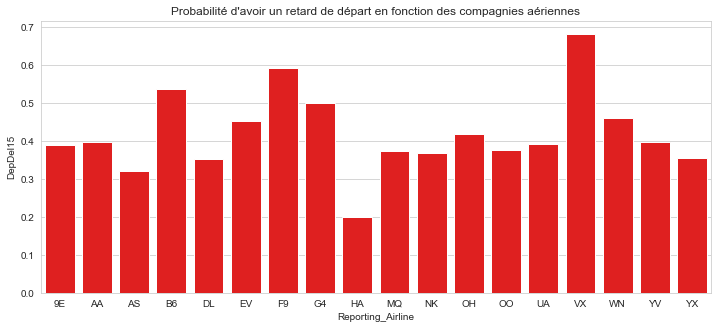

In [26]:
plt.figure(figsize=(12, 5))
airline_grouped = data.groupby('Reporting_Airline').mean()
sns.barplot(x=airline_grouped.index, y ="DepDel15", data=airline_grouped, color ='red')
fig = plt.title("Probabilité d'avoir un retard de départ en fonction des compagnies aériennes")

➠ On remarque que les compagnies aériennes "VX" (Virgin America), "B6"(JetBlue Airways) et "F9"(Frontier Airlines) semblent avoir une probabilté de retards d'arrivée de vol très importantes.

** Aéroport d'origine et de destination **

In [27]:
def fn_plot(feature,xlabel):
    plt.figure(figsize=(12, 5))
    grouped1 = data.groupby(feature)["ArrDel15"].sum()
    grouped2 = data.groupby(feature)["ArrDel15"].count()
    grouped = pd.concat([grouped1, grouped2],axis=1, keys=["sum", "count"])
    grouped["Probability of Arrival Delay15"] = grouped["sum"]/grouped["count"]
    grouped.sort_values(by = "Probability of Arrival Delay15", ascending = False, inplace = True)
    sns.set_style('whitegrid')
    sns.violinplot(x=grouped.index, y = "Probability of Arrival Delay15", data=grouped, color ='red')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    plt.xlabel(xlabel)
    plt.ylabel("Probability of Arrival Delay15")

On affcihe la probabilité d'avoir un retard d'arrivée en fonction d'aéroport d'origine.

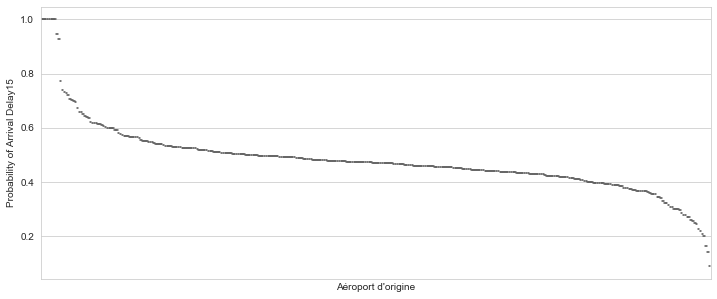

In [28]:
fn_plot('Origin', 'Aéroport d\'origine')

L'axe des abscisses dans ce graphe represente les différents aeroports d'origine.oOn peut ainsi constater depuis ce nuage de points que la probabilité de retard est fortement corrélée aux aéroports d'origine.

On affcihe la probabilité d'avoir un retard d'arrivée en fonction d'aéroport de destination.

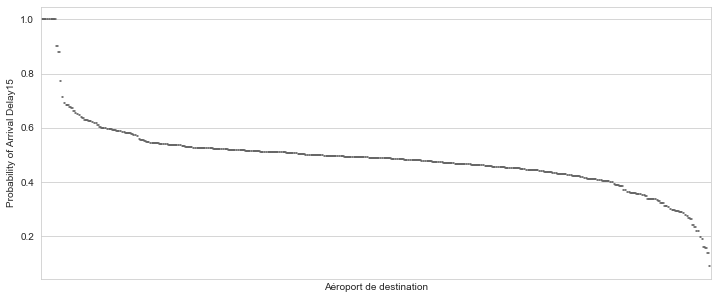

In [29]:
fn_plot('Dest', 'Aéroport de destination')

**Intnéraire de vol**

Nous avons crée ne nouvelle colonne appelée "Flight routes" avec l'aéroport d'origine et l'aéroport de destination

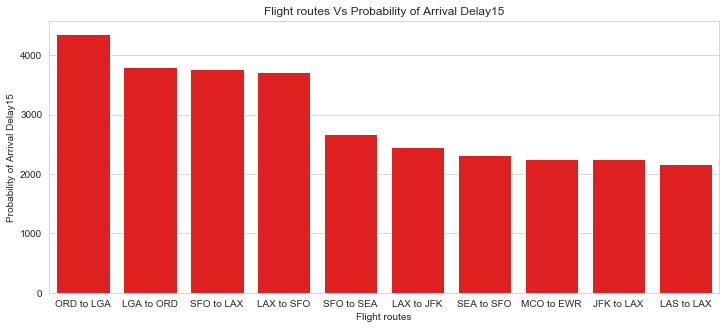

In [30]:
plt.figure(figsize = (12, 5))
data["Flight_route"] = data["Origin"] + " to " + data["Dest"]
flightroute = data.groupby('Flight_route').sum()
flightroute.sort_values(by = "ArrDel15", axis = 0, ascending = False, inplace = True)
sns.set_style('whitegrid')
fig = sns.barplot(x=flightroute.index[:10], y = "ArrDel15", data=flightroute[:10], color ='red')
fig.set(xlabel = 'Flight routes', ylabel = 'Probability of Arrival Delay15')
fig = plt.title("Flight routes Vs Probability of Arrival Delay15")

➠ Le graphe ci-dessus montre les 10 principales routes de vol avec un nombre plus élevé de retards à l'arrivée. Il est donc important d'inclure les colonnes de distance et de la duréé de vol dans cette analyse pour déterminer si elles jouent un rôle majeur dans la prévision des arrivées de vols.

**Les colonnes qui ne contiennent pas d'informations pertinentes et les colonnes qui contiennent des informations pertinentes mais redondantes ne sont pas incluses dans cette analyse**

In [31]:
for i in data.columns:
    print (i, data[i].nunique())

Quarter 4
Month 5
FlightDate 365
Reporting_Airline 18
DOT_ID_Reporting_Airline 18
IATA_CODE_Reporting_Airline 18
Tail_Number 5717
Flight_Number_Reporting_Airline 7109
OriginAirportID 358
OriginAirportSeqID 360
OriginCityMarketID 334
Origin 358
OriginCityName 352
OriginState 52
OriginStateFips 52
OriginStateName 52
OriginWac 52
DestAirportID 358
DestAirportSeqID 360
DestCityMarketID 334
Dest 358
DestCityName 352
DestState 52
DestStateFips 52
DestStateName 52
DestWac 52
DepTime 1440
DepDelay 1475
DepDelayMinutes 1417
DepDel15 2
DepartureDelayGroups 15
DepTimeBlk 19
TaxiOut 180
WheelsOff 1440
WheelsOn 1440
TaxiIn 205
ArrTime 1440
ArrDelay 1518
ArrDelayMinutes 1426
ArrDel15 2
ArrivalDelayGroups 15
ArrTimeBlk 19
Cancelled 1
Diverted 1
CRSElapsedTime 564
ActualElapsedTime 701
AirTime 672
Distance 1536
DistanceGroup 11
DivAirportLandings 1
Week 2
Arrival_Time 3
Departure_Time 3
Flight_route 6272


In [32]:
important_columns = ['Reporting_Airline','Origin', 'Distance','AirTime','ArrDel15','Month', 'Week', 'Arrival_Time','TaxiOut', 'TaxiIn']
for column in data.columns:
    if not column in important_columns:
        data = data.drop(column, axis=1)

In [33]:
data.shape

(2705420, 10)

In [34]:
data.columns

Index(['Month', 'Reporting_Airline', 'Origin', 'TaxiOut', 'TaxiIn', 'ArrDel15',
       'AirTime', 'Distance', 'Week', 'Arrival_Time'],
      dtype='object')

On va séparer les attributs en numeric_attributs et categorical_attributs.

In [35]:
numeric_attributs = data._get_numeric_data().columns.values.tolist()
categorical_attributs = [i for i in data.columns if not i in numeric_attributs]
numeric_attributs.remove('ArrDel15')
print('Attributs numériques : ', numeric_attributs)
print('Attributs catégoriques : ', categorical_attributs)

Attributs numériques :  ['TaxiOut', 'TaxiIn', 'AirTime', 'Distance']
Attributs catégoriques :  ['Month', 'Reporting_Airline', 'Origin', 'Week', 'Arrival_Time']


On calcule les corrélations entre les attributs numériques de l'ensemble de données.

Les fonctions suivantes permettent d'achever cette tache

In [36]:
print("Matrice de corrélation")
check_cor = data[numeric_attributs]
print(check_cor.corr())
def get_pairs(dat):
    pairs_to_drop = set()
    cols = dat.columns
    for i in range(0, dat.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(dat, n=5):
    cal_corr = dat.corr().abs().unstack()
    labels_to_drop = get_pairs(dat)
    cal_corr = cal_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return cal_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(check_cor, 2))

Matrice de corrélation
           TaxiOut    TaxiIn   AirTime  Distance
TaxiOut   1.000000  0.020910  0.044166  0.025657
TaxiIn    0.020910  1.000000  0.083143  0.071092
AirTime   0.044166  0.083143  1.000000  0.980706
Distance  0.025657  0.071092  0.980706  1.000000
Top Absolute Correlations
AirTime  Distance    0.980706
TaxiIn   AirTime     0.083143
dtype: float64


Il existe une forte corrélation entre la distance et la durée de vol, donc on va supprimer cette colonne.

In [37]:
data.drop(["AirTime"], axis = 1, inplace = True)

In [38]:
data.columns

Index(['Month', 'Reporting_Airline', 'Origin', 'TaxiOut', 'TaxiIn', 'ArrDel15',
       'Distance', 'Week', 'Arrival_Time'],
      dtype='object')

Maintenant, nous devons transformer les attributs catégoriques en attributs numériques.

In [39]:
for attribut in categorical_attributs:
    encoder = LabelEncoder()
    encoded_values = encoder.fit_transform(data[attribut].values)
    data[attribut] = pd.Series(encoded_values, index=data.index)

In [40]:
clean_data = data

In [41]:
print ("Le nombre final de lignes utilisées dans la classification : ", len(clean_data))
print ("Le nombre final de colonnes utilisées dans la classification : ",(clean_data.shape[1]))

Le nombre final de lignes utilisées dans la classification :  2705420
Le nombre final de colonnes utilisées dans la classification :  9


In [42]:
features = []
for i in clean_data.columns:
    if i != "ArrDel15":
        features.append(i)

# Extraction des connaissances et évaluation

La première étape consiste à diviser le dataset en training et test sets

In [43]:
target_feature = clean_data['ArrDel15']
clean_data.drop('ArrDel15', axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(clean_data,target_feature ,test_size=0.25, random_state=0)

## Classification

### Decision Tree

In [44]:
dec_tree_model = DecisionTreeClassifier(criterion='entropy' , max_depth = 10)
dec_tree_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [45]:
dec_tree_model_pred = dec_tree_model.predict(x_test)

In [46]:
dec_tree_model.score(x_test, y_test)

0.6444648150749237

### Random forest

In [47]:
rand_forest_model =RandomForestClassifier(n_estimators=50)
rand_forest_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
rand_forest_model_pred = rand_forest_model.predict(x_test)

In [49]:
rand_forest_model.score(x_test, y_test)

0.6452646908797894

### Naive Bayes

In [51]:
n_bayes_model = naive_bayes.MultinomialNB(fit_prior=True)
n_bayes_model.fit(x_train, y_train) 

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [52]:
n_bayes_model_pred = n_bayes_model.predict(x_test)

In [53]:
n_bayes_model.score(x_test, y_test)

0.5648202497209306

➠ D'après les scores obtenus, le classifieur Random forest a donné le meilleur résultat avec une très légère différence par rapport au classifieur Decision Tree. Puisque Random Forest a une complexité supérieure au Decesion Tree nous considérons ce dernier comme modèle de prédicition.